# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.manifold import TSNE
import sklearn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Device

Set device to work with (GPU or CPU)

In [2]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [4]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
data_dir = './data/cifar10'
classes = os.listdir(data_dir + "/train")

In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

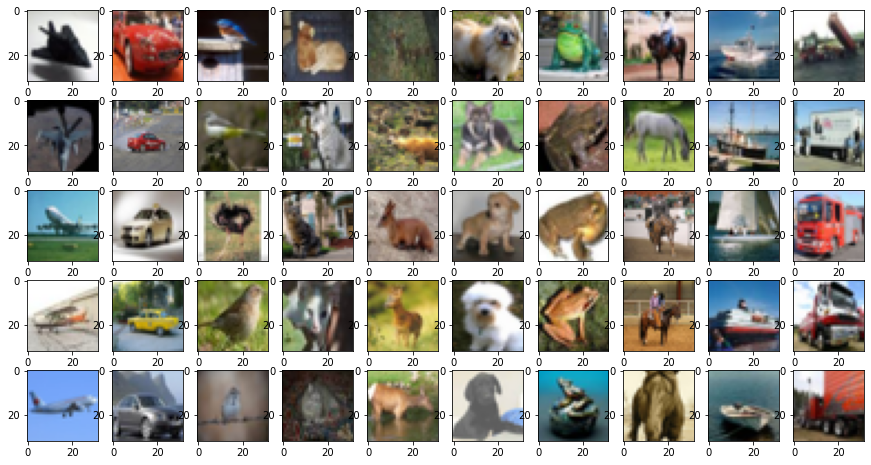

In [ ]:
plt.figure(figsize=[15,8])
def show_example(i, img, label):
    plt.subplot(5, 10, i);plt.imshow(img.permute(1, 2, 0) ,cmap='gray');
show_list = [0, 5001, 10001, 15001, 20001, 25001, 30001, 35001, 40001, 45001,
            10, 5010, 10010, 15010, 20010, 25010, 30010, 35010, 40010, 45010,
            100, 5100, 10100, 15100, 20100, 25100, 30100, 35100, 40100, 45100,
            300, 5300, 10300, 15300, 20300, 25300, 30300, 35300, 40300, 45300,
            500, 5500, 10500, 15500, 20500, 25500, 30500, 35500, 40500, 45500
            ]
for i in range(1, 51):
    show_example(i, *dataset[show_list[i-1]])

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [ ]:
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, pin_memory=True)

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.3930, val_loss: 1.1170, val_acc: 0.6122
Epoch [1], train_loss: 0.9116, val_loss: 0.8771, val_acc: 0.7026
Epoch [2], train_loss: 0.7542, val_loss: 0.8807, val_acc: 0.6966
Epoch [3], train_loss: 0.6619, val_loss: 0.8825, val_acc: 0.7027
Epoch [4], train_loss: 0.5945, val_loss: 0.6224, val_acc: 0.7933
Epoch [5], train_loss: 0.5376, val_loss: 0.5653, val_acc: 0.8064
Epoch [6], train_loss: 0.4950, val_loss: 0.5514, val_acc: 0.8131
Epoch [7], train_loss: 0.4511, val_loss: 0.5664, val_acc: 0.8081
Epoch [8], train_loss: 0.4126, val_loss: 0.4986, val_acc: 0.8294
Epoch [9], train_loss: 0.3896, val_loss: 0.5160, val_acc: 0.8315
Epoch [10], train_loss: 0.3543, val_loss: 0.5245, val_acc: 0.8299
Epoch [11], train_loss: 0.3369, val_loss: 0.4706, val_acc: 0.8476
Epoch [12], train_loss: 0.3100, val_loss: 0.4945, val_acc: 0.8430
Epoch [13], train_loss: 0.2857, val_loss: 0.5100, val_acc: 0.8426
Epoch [14], train_loss: 0.2701, val_loss: 0.4560, val_acc: 0.8626
Epoch [15], train_lo

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

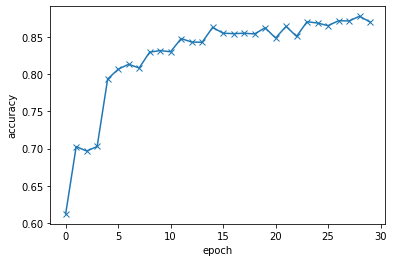

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
plot_accuracies(history)

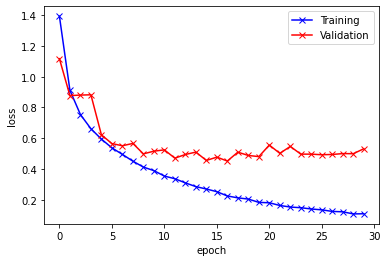

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
plot_losses(history)

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds  = torch.max(yb, dim=1)
  return dataset.classes[preds[0].item()]

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8680664300918579, 'val_loss': 0.5166835188865662}

## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

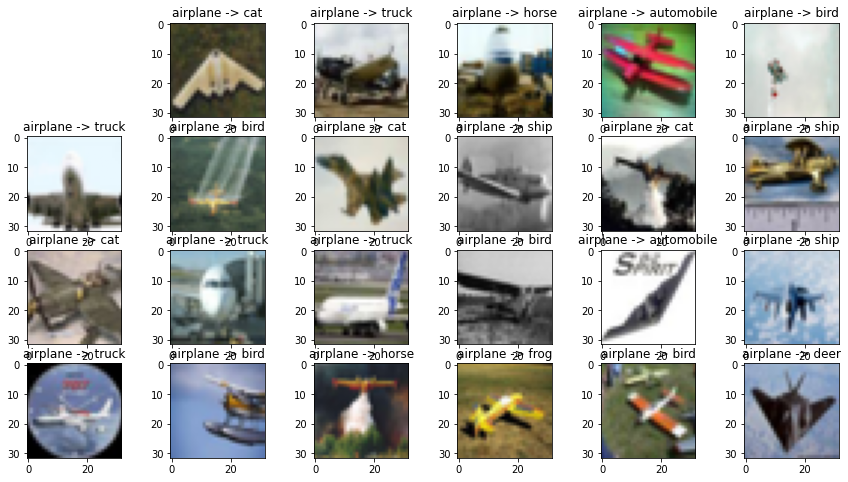

In [ ]:
plt.figure(figsize=[15,8])
def show_example(true_one, my_one, i, img, label="nothing"):
    plt.subplot(4, 6, i);plt.imshow(img.permute(1, 2, 0) ,cmap='gray');plt.title(f"{true_one} -> {my_one}");

counter = 1
for i in range(10000):
  img, label = test_dataset[i]
  true_label = dataset.classes[label]
  my_label = predict_image(img, model)
  if true_label != my_label:
    counter += 1
    show_example(true_label, my_label, counter, img)
  if counter == 24:
    break

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
if 'feature_space' in locals():
  del feature_space
feature_space = {"airplane": [], "automobile": [], "bird": [], "cat": [], "deer": [], "dog": [], "frog": [], "horse": [], "ship": [], "truck": []}
main_matrice = (model.network[-1].weight)

# actually I can only save 7000 of feature space
# otherwise I will get OUT OF MEMORY Exception
for i in range(1, 45000, 10):
  img, label = train_ds[i]
  true_label = dataset.classes[label]
  xb = to_device(img.unsqueeze(0), device)
  output = model(xb)
  multiplication = torch.matmul(output, main_matrice)
  norm = torch.norm(multiplication)
  feature_space[true_label].append(norm)

print(len(feature_space["airplane"]))
print(len(feature_space["bird"]))
print(len(feature_space["dog"]))
print(len(feature_space["horse"]))
print(len(feature_space["truck"]))

435
480
423
440
431


### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

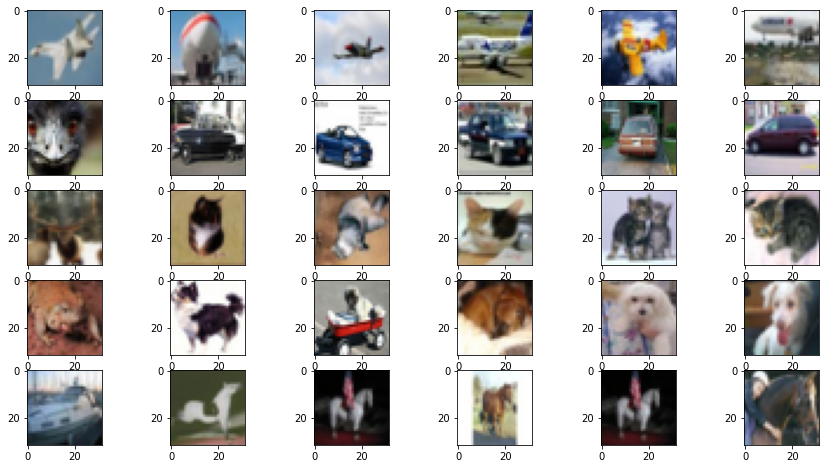

In [ ]:
plt.figure(figsize=[15,8])
def show_example(i, img):
    plt.subplot(5, 6, i);plt.imshow(img.permute(1, 2, 0) ,cmap='gray');

def find_nearest(main_dot, label):
  lowest = []
  min_one = 1000000
  index_min = -1
  counter = 0
  for i in feature_space[label]:
    if abs(main_dot - i) < min_one:
      min_one = abs(main_dot - i)
      index_min = counter
    counter += 1
  lowest = [feature_space[label][index_min].item(), feature_space[label][index_min-1].item(), feature_space[label][index_min+1].item(), feature_space[label][index_min-2].item(), feature_space[label][index_min+2].item()]
  return lowest

main_counter = 1
for i in range(1, 10000, 2000):
  img, upper_label = test_dataset[i]
  true_label = dataset.classes[upper_label]
  xb = to_device(img.unsqueeze(0), device)
  output = model(xb)
  multiplication = torch.matmul(output, main_matrice)
  norm = torch.norm(multiplication)
  nearest = find_nearest(norm, true_label)
  show_example(main_counter, img)
  main_counter += 1
  for j in nearest:
    rounded = int(j)
    img, label = dataset[upper_label * 4500 + rounded]
    show_example(main_counter, img)
    main_counter += 1

### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [ ]:
if 'feature_space' in locals():
  del feature_space
feature_space = []

for i in range(1, 40001, 20):
  img, label = train_ds[i]
  xb = to_device(img.unsqueeze(0), device)
  output = model(xb)
  multiplication = torch.matmul(output, main_matrice)
  multiplication = multiplication.cpu()
  multiplication = multiplication.tolist()
  feature_space.append(multiplication[0])

feature_space = np.asarray(feature_space)
print(feature_space.shape)

(2000, 512)


In [ ]:
X_embedded = TSNE().fit_transform(feature_space)
print(X_embedded.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2000, 2)


Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

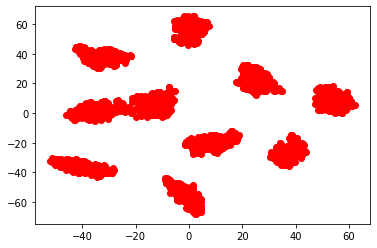

In [ ]:
# sorry I did not save thier labels, so I draw all of them in red
# But I think that the general Scehma is correct and done correctly
for i in X_embedded:
  plt.scatter(i[0], i[1], color="red")
plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [7]:
import sys

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
num_epochs = 30
batch_size = 512
learning_rate = 1e-3
use_gpu = True

In [9]:
import numpy as np
from skimage import color

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])

train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1))

    def forward(self, input):
        return self.network(input)

cnet = ColorNet()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
cnet = cnet.to(device)

num_params = sum(p.numel() for p in cnet.parameters() if p.requires_grad)

In [11]:
optimizer = torch.optim.Adam(params=cnet.parameters(), lr=learning_rate)

# set to training mode
cnet.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for lab_batch, _ in train_dataloader:
        
        lab_batch = lab_batch.to(device)
        
        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])
        
        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 30] average reconstruction error: 173.473553
Epoch [2 / 30] average reconstruction error: 154.964143
Epoch [3 / 30] average reconstruction error: 149.909689
Epoch [4 / 30] average reconstruction error: 145.885659
Epoch [5 / 30] average reconstruction error: 142.147056
Epoch [6 / 30] average reconstruction error: 137.836977
Epoch [7 / 30] average reconstruction error: 133.086763
Epoch [8 / 30] average reconstruction error: 127.388357
Epoch [9 / 30] average reconstruction error: 120.816532
Epoch [10 / 30] average reconstruction error: 114.857239
Epoch [11 / 30] average reconstruction error: 108.417336
Epoch [12 / 30] average reconstruction error: 102.642815
Epoch [13 / 30] average reconstruction error: 96.483764
Epoch [14 / 30] average reconstruction error: 91.457264
Epoch [15 / 30] average reconstruction error: 87.134288
Epoch [16 / 30] average reconstruction error: 83.495380
Epoch [17 / 30] average reconstruction error: 79.749537
Epoch [18 / 30] average reconstr

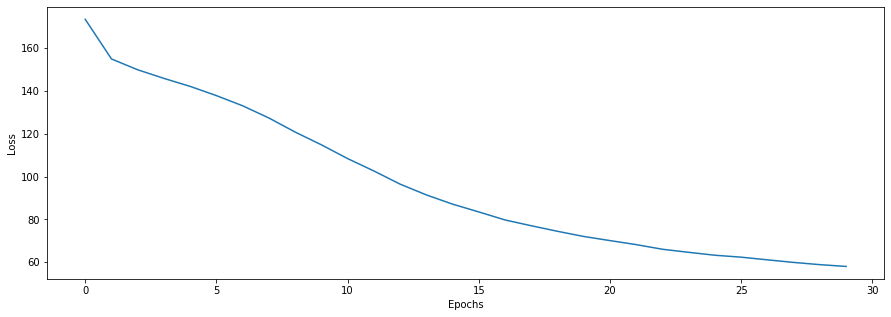

In [12]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [13]:
# set to evaluation mode
cnet.eval()

test_loss_avg, num_batches = 0, 0
for lab_batch, _ in test_dataloader:

    with torch.no_grad():

        lab_batch = lab_batch.to(device)

        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])

        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 174.370441


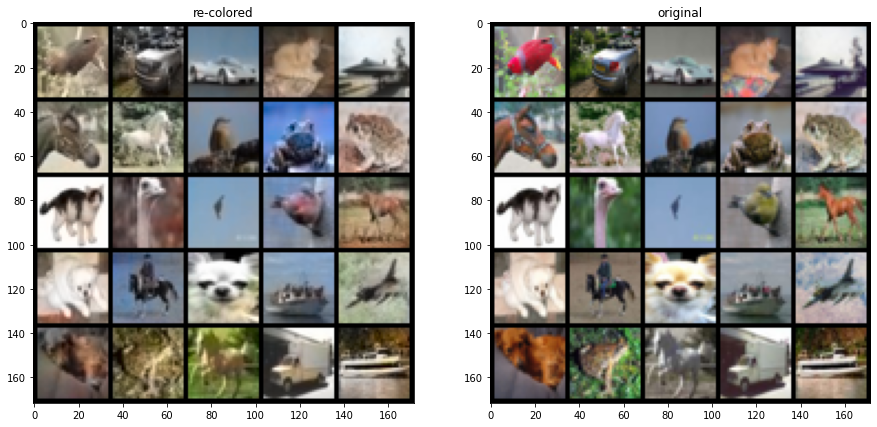

In [14]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(test_dataset), 25, replace=False)
    lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])
    lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()
